# Eigenfaces

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rputil import *
from PIL import Image
import glob
from time import time, perf_counter

from tqdm import notebook

from rputil import *

%matplotlib inline

In [2]:
n_images = 2000

data = np.empty((62500, n_images), dtype='uint8')

for i,filename in notebook.tqdm(enumerate(glob.iglob('lfw-funneled/lfw_funneled/**/*.jpg', recursive = True))):  #images are 250x250x3
    if i >= n_images:
        break
    im=Image.open(filename)
    arr = np.asarray(im, dtype='uint8')[:,:,0].flatten()
    data[:,i] = arr
    im.close()


In [3]:
data = data - np.expand_dims(np.mean(data, axis=1),1)

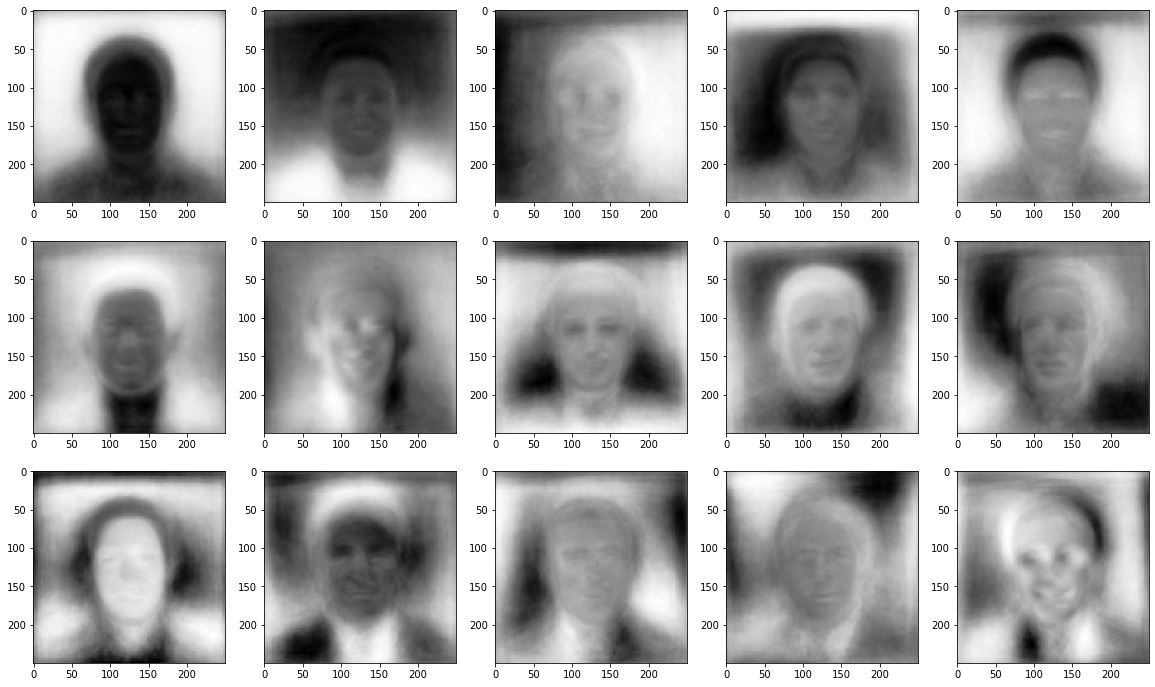

In [4]:
def svd_factor(A, k):
    u, sigma, vh = np.linalg.svd(A, full_matrices=False) #compute svd
    return u[:,:k]

rows, cols = (3,5)

start = perf_counter()
basis = svd_factor(data, rows*cols)
end = perf_counter()
t1 = end - start

fig, ax = plt.subplots(rows, cols, figsize=(20, 20 * rows / cols))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250), cmap='Greys')


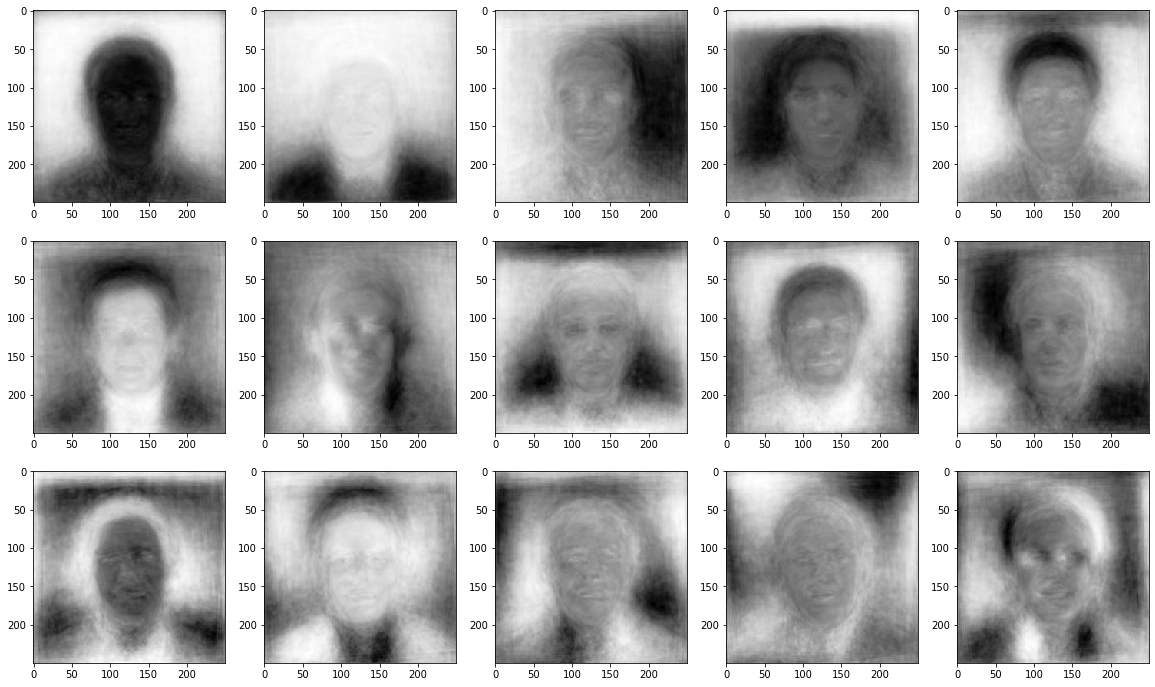

In [8]:
def rsvd_factor(A, rank, k): 
    omega = random.randn(A.shape[1],rank)
    Y = A @ omega
    Q, R = np.linalg.qr(Y)
    B = Q.T @ A
    U_tilde, Sigma, Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    return U[:,:k]


rows, cols = (3,5)

start = perf_counter()
basis = rsvd_factor(data, n_images // 4, rows*cols)
end = perf_counter()
t2 = end - start

fig, ax = plt.subplots(rows, cols, figsize=(20, 20 * rows / cols))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250), cmap='Greys')


In [9]:
print(f"SVD time : {t1}. RSVD time: {t2}")

SVD time : 61.5191947. RSVD time: 12.365973499999996
